### Setup

In [1]:
with open('./tiny_shakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [2]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115393


In [4]:
# let's look at the first 1000 characters
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [3]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [4]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [5]:
# storing the encoded text in tensor
import torch
data = torch.tensor(encode(text), dtype = torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # first 1000 characters token ids

torch.Size([1115393]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [6]:
# split train/val
n = int(len(data)*0.9)
train_data = data[:n]
val_data = data[n:]

input to the Transformer while training isn't the whole sequence [computationally expensive and usually infeasible] instead its some random continuous chunks of the sequence. The length of these chunks is fixed, called context length of the model

For a decoder transformer, the training is done iteratively over a given chunk.
Say we had the chunk [1, 2, 6, 3, 8, 4, 5, 0, 9], given no context, model should predict 1, given 1 it should predict 2. Given 1,2 predict 6. Given 1,2,6 -> 3 and so on...

Similarly, while testing/inference, the model can generate the next token based on only the previous ```context_length``` number of tokens [characters in our case], once the context_length is reached, it starts predicting on the next window of ```context_length``` while ignoring the any previous tokens

In [7]:
block_size = 8 # max context length of our model
x = train_data[:block_size+1]
labels = train_data[:block_size+1]
for i in range(1, block_size+1):
    print("Input Sequence: ", x[:i], ' --> Predicted label: ', labels[i])

Input Sequence:  tensor([18])  --> Predicted label:  tensor(47)
Input Sequence:  tensor([18, 47])  --> Predicted label:  tensor(56)
Input Sequence:  tensor([18, 47, 56])  --> Predicted label:  tensor(57)
Input Sequence:  tensor([18, 47, 56, 57])  --> Predicted label:  tensor(58)
Input Sequence:  tensor([18, 47, 56, 57, 58])  --> Predicted label:  tensor(1)
Input Sequence:  tensor([18, 47, 56, 57, 58,  1])  --> Predicted label:  tensor(15)
Input Sequence:  tensor([18, 47, 56, 57, 58,  1, 15])  --> Predicted label:  tensor(47)
Input Sequence:  tensor([18, 47, 56, 57, 58,  1, 15, 47])  --> Predicted label:  tensor(58)


In [8]:
torch.manual_seed(1337)
batch_size = 4 # number of independent sequences (chunks) processed in parallel [same as mini-batch]
block_size = 8 # maximum context length for predictions

def get_batch(split):
    # generating small batches of inputs x and labels y
    data = train_data if split == 'train' else val_data
    # sample random integers [indexes in the data] representing the starting indices of the `block_size` sized chunks
    # hence, subtracting block_size [max start index + block_size can't be greater than total data length]
    # (batch_size,) - take only batch_size number of starting indices
    ix = torch.randint(len(data) - block_size, (batch_size, )) # this only takes
    # for each of the above starting indices, take block_sized continuous sequence of tokens as sinlge training example
    # print(ix.shape)
    x = torch.stack([data[i:i+block_size] for i in ix]) # block_sized sequence
    y = torch.stack([data[i+1:i+block_size+1] for i in ix]) # (block_size+1)th token as label!
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

inputs:
torch.Size([4, 8])
tensor([[53, 59,  6,  1, 58, 56, 47, 40],
        [49, 43, 43, 54,  1, 47, 58,  1],
        [13, 52, 45, 43, 50, 53,  8,  0],
        [ 1, 39,  1, 46, 53, 59, 57, 43]])
targets:
torch.Size([4, 8])
tensor([[59,  6,  1, 58, 56, 47, 40, 59],
        [43, 43, 54,  1, 47, 58,  1, 58],
        [52, 45, 43, 50, 53,  8,  0, 26],
        [39,  1, 46, 53, 59, 57, 43,  0]])


### Bigram LM
- Let's implement the simplest LM

In [9]:
print("input to the model: ", xb)

input to the model:  tensor([[53, 59,  6,  1, 58, 56, 47, 40],
        [49, 43, 43, 54,  1, 47, 58,  1],
        [13, 52, 45, 43, 50, 53,  8,  0],
        [ 1, 39,  1, 46, 53, 59, 57, 43]])


In [12]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [13]:
torch.manual_seed(1337)
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) 
        # (B,T,C) - B is the batch size (4), 
        # T is the time dimension/context length/block size (8), 
        # C is the possible output classes/vocab size here (65)

        # if targets available, measure the loss
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C) # torch implementation of cross entropy expects inputs shaped like this
            targets = targets.view(B*T) # explicit shape, can be simply -1
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        # based on the max_tokens requested, the model iteratively predicts tokens one-by-one till max_tokens are reached
        for _ in range(max_new_tokens):
            # get the predictions at current time step
            logits, loss = self(idx) 
            # we are passing all the context till now for predicting next
            # not desired for bigram model, but done for future flexibility when we go to higher context sizes
            # focus only on the last time step as its bigram, 
            # i.e. the logits plucked from the embedding table for the last character in sequence so far
            # e.g.: if sequence KJbsilkhIHS;[];sskhfa]w then we get logits corresponding to 'w' only
            # convert them to prob distribution using softmax and sample multinomial
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

torch.Size([32, 65])
tensor(4.8948, grad_fn=<NllLossBackward0>)


Expected initial loss = -log(1/vocab_size) = -log(1/65) ~ 4.17

In [37]:
# kick off the generation starting from token id 0 (newline?)
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


Random Garbage as output, let's train the model

In [26]:
# create PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3) # for bigger models standard learning rate is ~ 1e-4

In [33]:
batch_size = 32
for steps in range(10000):

    # sample batch of data
    xb, yb = get_batch('train')

    # evaluate loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none = True) # setting gradients to None first
    loss.backward()
    optimizer.step()

print(loss.item())

2.5974185466766357


In [34]:
# Let's check the generation now after training some timesteps
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))



We divigileve theran' lim lleais woug! shchestt wengerrounde athor I l hit g Yonces efe o has inke 


Much better!

### Math trick in self-attention

In [10]:
# an example
torch.manual_seed(1337)
B, T, C = 4, 8, 2 # batch, time, channel
x = torch.randn(B, T, C)
x.shape

torch.Size([4, 8, 2])

for each batch, for every Tth token, take mean of all the tokens till now + Tth

#### naive implementation

In [39]:
# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C)) # bag of words
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t+1,C) - prev tokens + current token from a given batch b
        xbow[b,t] = torch.mean(xprev, 0) # average along dimension 0 [time]


In [40]:
x[0]

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])

In [41]:
xbow[0]

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])

- notice how first row is same (1,C) as its average of itself
- 2nd is average of 1st and 2nd token

but this is inefficient with the loops, we can use matrix multiplication

#### mimic above using matrix multiplication

##### small example

In [45]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3)) # lower triangular matrix of the input matrix
print(a)
a = a / torch.sum(a, 1, keepdim=True) # scaled by the number of elements to average out; normalize rows of a to 1
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


##### cross apply

In [48]:
# let's use matrix mult here
# We want x[b,t] = mean_{i<=t} x[b,i]
# we need TXT matrix
average_self_attention = torch.tril(torch.ones(T, T))
average_self_attention = average_self_attention/average_self_attention.sum(1, keepdim=True)
average_self_attention

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [50]:
xbow2 = average_self_attention @ x # torch converts (T, T) @ (B, T, C) to (B, T, T) @ (B, T, C) by adding a batch dimension to the 
# first matrix and taking matmul over all the batches
torch.allclose(xbow2, xbow)

True

In [51]:
xbow[0], xbow2[0] # check first batch, its same

(tensor([[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]]),
 tensor([[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]]))

#### using softmax for the same!

In [54]:
matrix = torch.zeros((T, T))
tril = torch.tril(torch.ones(T, T))
matrix = matrix.masked_fill(tril == 0, float('-inf')) # wherever the tril matrix is 0 fill it with -inf
matrix

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [55]:
# imagine taking softmax on each row of the above matrix
matrix = F.softmax(matrix, dim=-1) # last dimension -1
matrix # exactly what we want

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [56]:
xbow3 = matrix @ x
torch.allclose(xbow, xbow3)

True

#### Actual self-attention

instead of taking average of all the prev tokens (all prev words equally important to the current word),

now we dive into the actual self-attention mechanism:
- intuition is to let the data drive the weights (importance) of other tokens w.r.t current token
- each token has 2 information -> query, key
- query represents what is the current token looking for?
- key represents what the current token contains
- affinities derived via dot product between current token query with the keys (content) of all the other tokens
- these affinities now become weights (importance) of the other tokens w.r.t current token

this is a single head of self-attention, then comes multi-head attention:
- the same process can be repeated 'N' (number of heads) times independent of other heads
- the results from each head are then combined

In [14]:
# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16 # single head with size 16 [can imagine as num dimensions of information]
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False) # 
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf')) # required for decoder block - autoregressive setting [no info of future tokens]
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v
#out = wei @ x

out.shape

torch.Size([4, 8, 16])

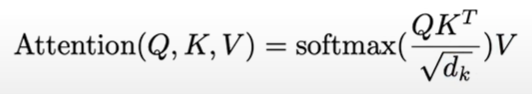

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

In [15]:
k = torch.randn(B, T, head_size)
q = torch.randn(B, T, head_size)
wei = q @ k.transpose(-2, -1) # which of the 2 adjacent dimensions to transpose?? here, we want innermost matrix transposed, last 2 dims -2, -1

In [16]:
# check variance of each tensor
k.var(), q.var(), wei.var()

(tensor(1.0449), tensor(1.0700), tensor(17.4690))

* notice how weights have very high variance even though keys and queries are standard gaussian
* also notice how its very close to the head_size (16 here)
* Reason:
    - What is the variance of product of two random variables? If mean of X and Y == 0, Var(XY) = Var(X)*Var(Y)
    - What is the variance of sum of random variables? Var(X+Y) = Var(X) + Var(Y)
    - in matrix multiplication, each pij = summation(aik*bkj)
    - each aik*bkj retains the original variance but the summation adds up the variances! And we have k = 16 (head_size)
    - hence the composite random variable made out of the matrix mult operation has variance of head_size
    - multiplying by 1/sqrt(head_size) ensures the Var of ~ head_size becomes Var*(1/head_size) ~ 1
* If we ensure Var of hidden states is ~ 1, we can have more equitable softmax. For high variance in the hidden states, softmax becomes highly skewed.

* To understand why this happens we can look at the graphs of e^x and x+1
    - e^x is almost linear for x [-1, 1] but as we go further away from this range, the difference becomes exponentially large
    - leading to output of skewed prob distribution from softmax
    
* Proof in images below

Another question is why we want the softmax to be equitably distributed??
- We are building attention layer
- our end goal is to get the amount of attentions each token shoould pay to other tokens
- if we have a skewed prob dist, it means any given token would pay attention to 1 or 2 other tokens in the sequence at max
- whereas, when the prob dist is equitable, each token can pay better attention to all important tokens (instead of just 1 or 2 skewed ones)!

#### PROOFS

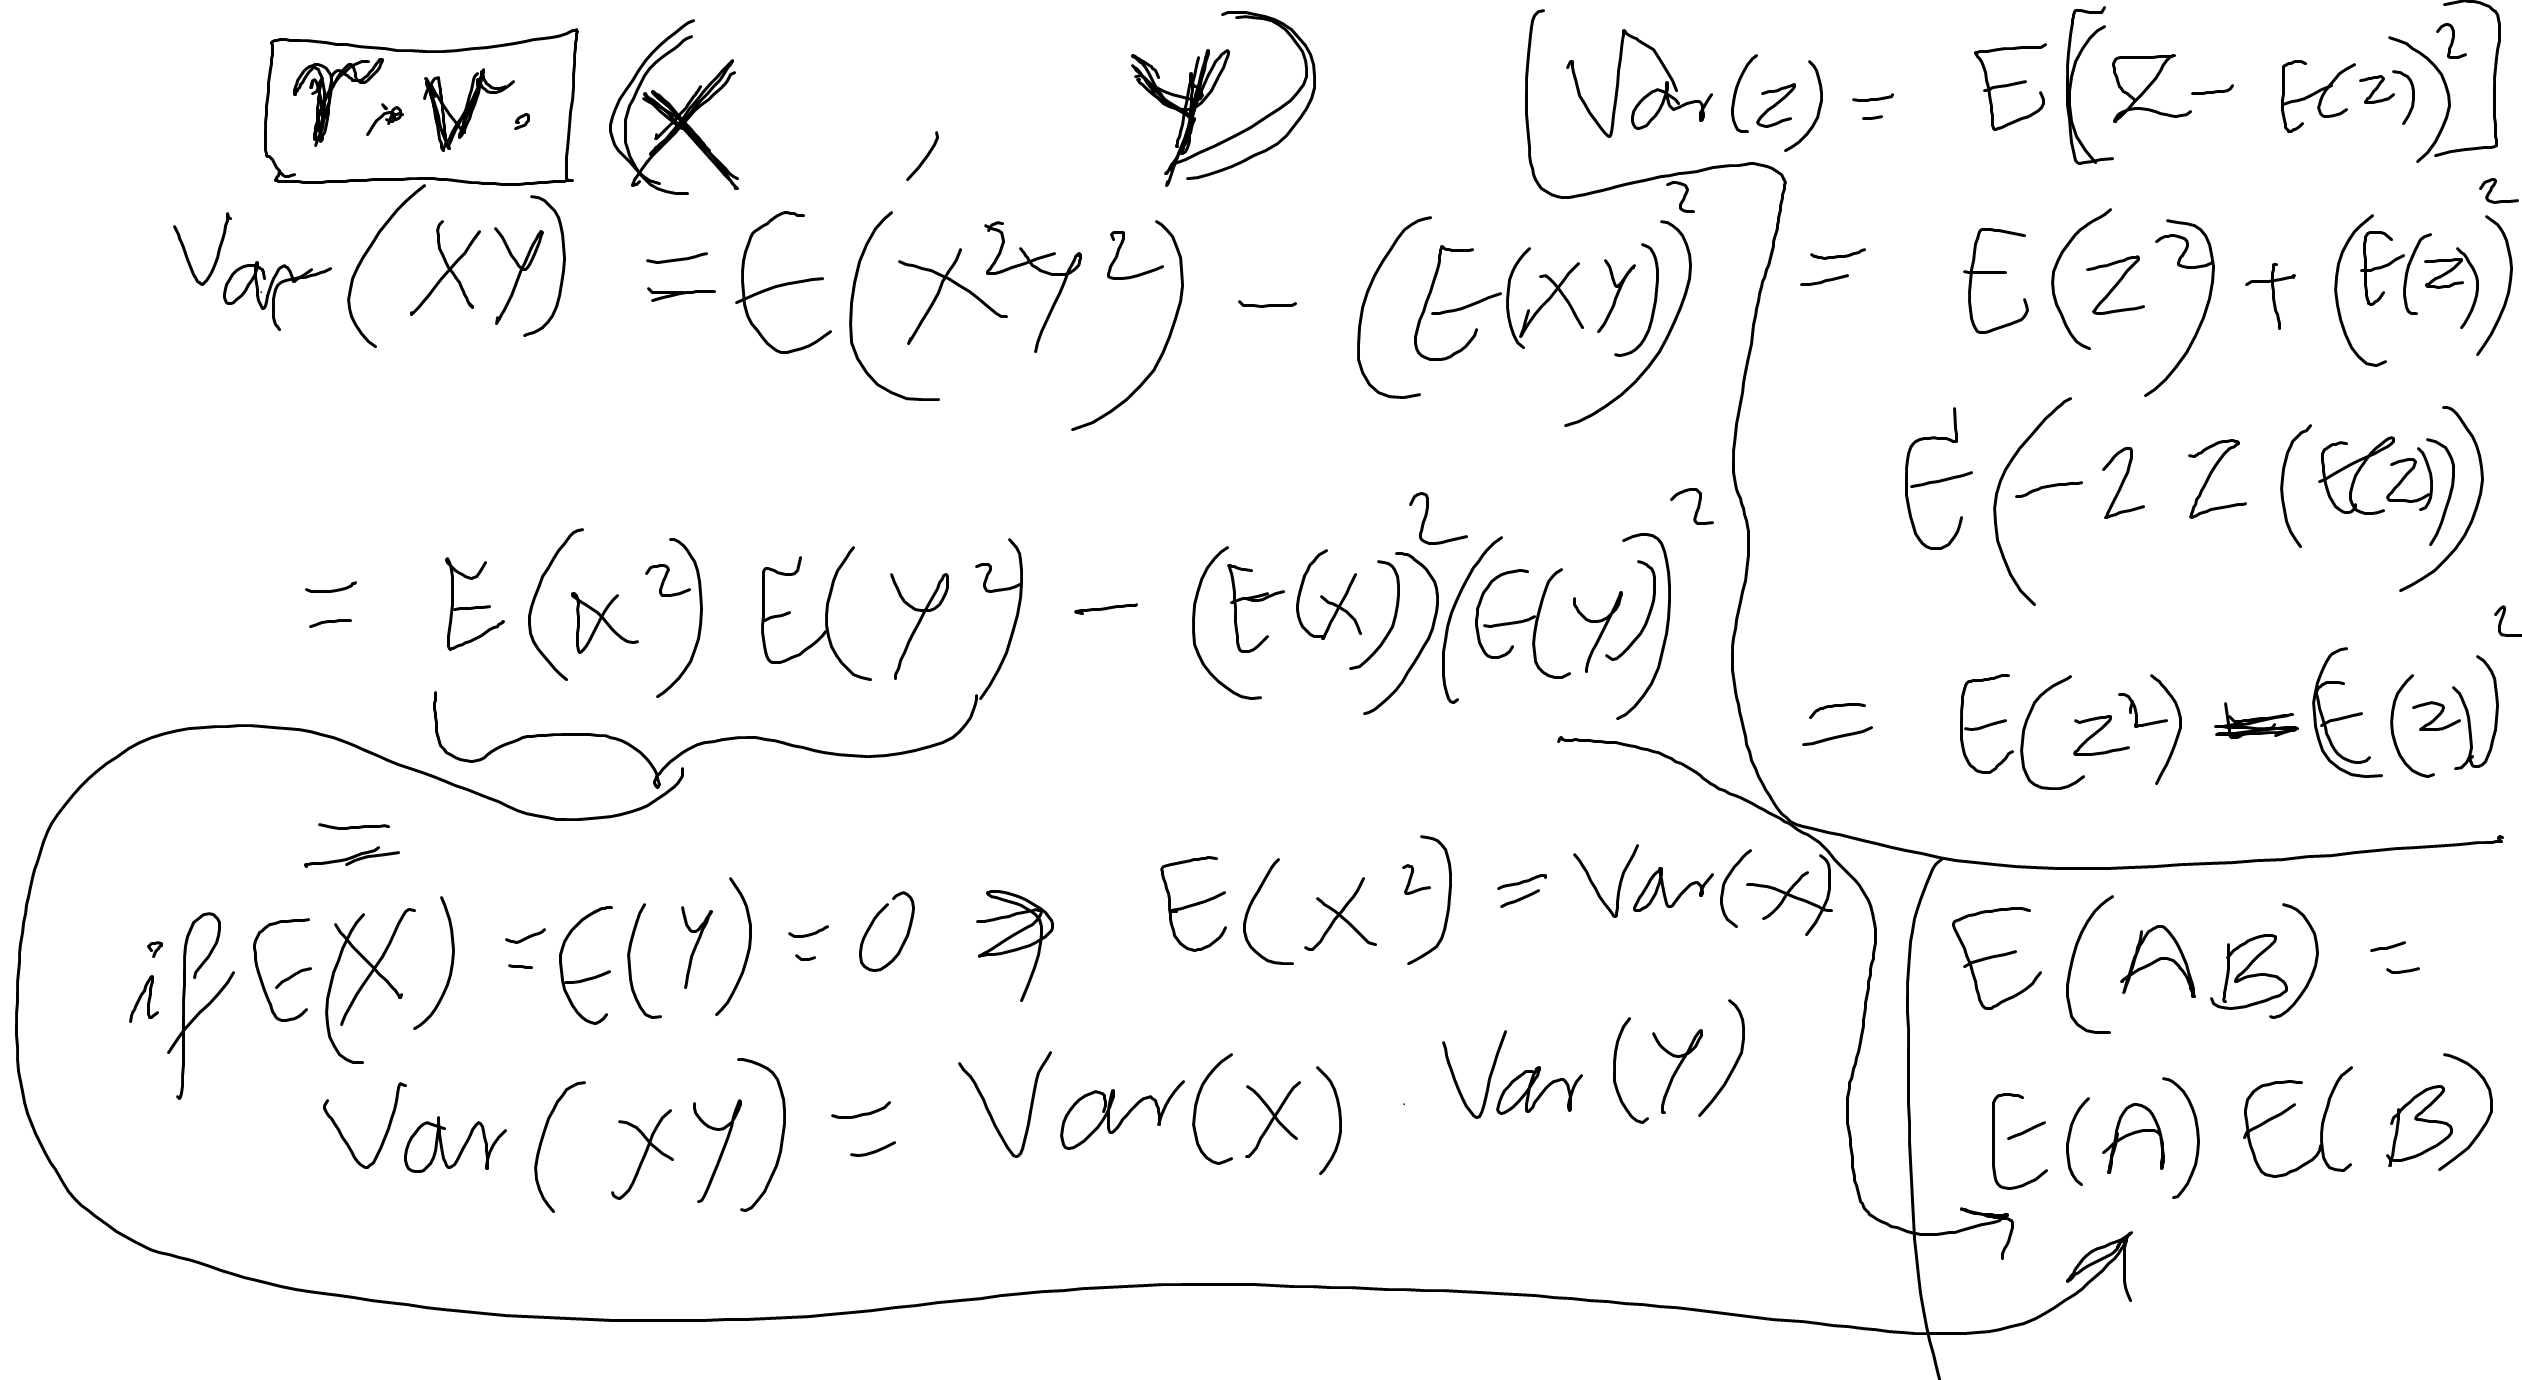

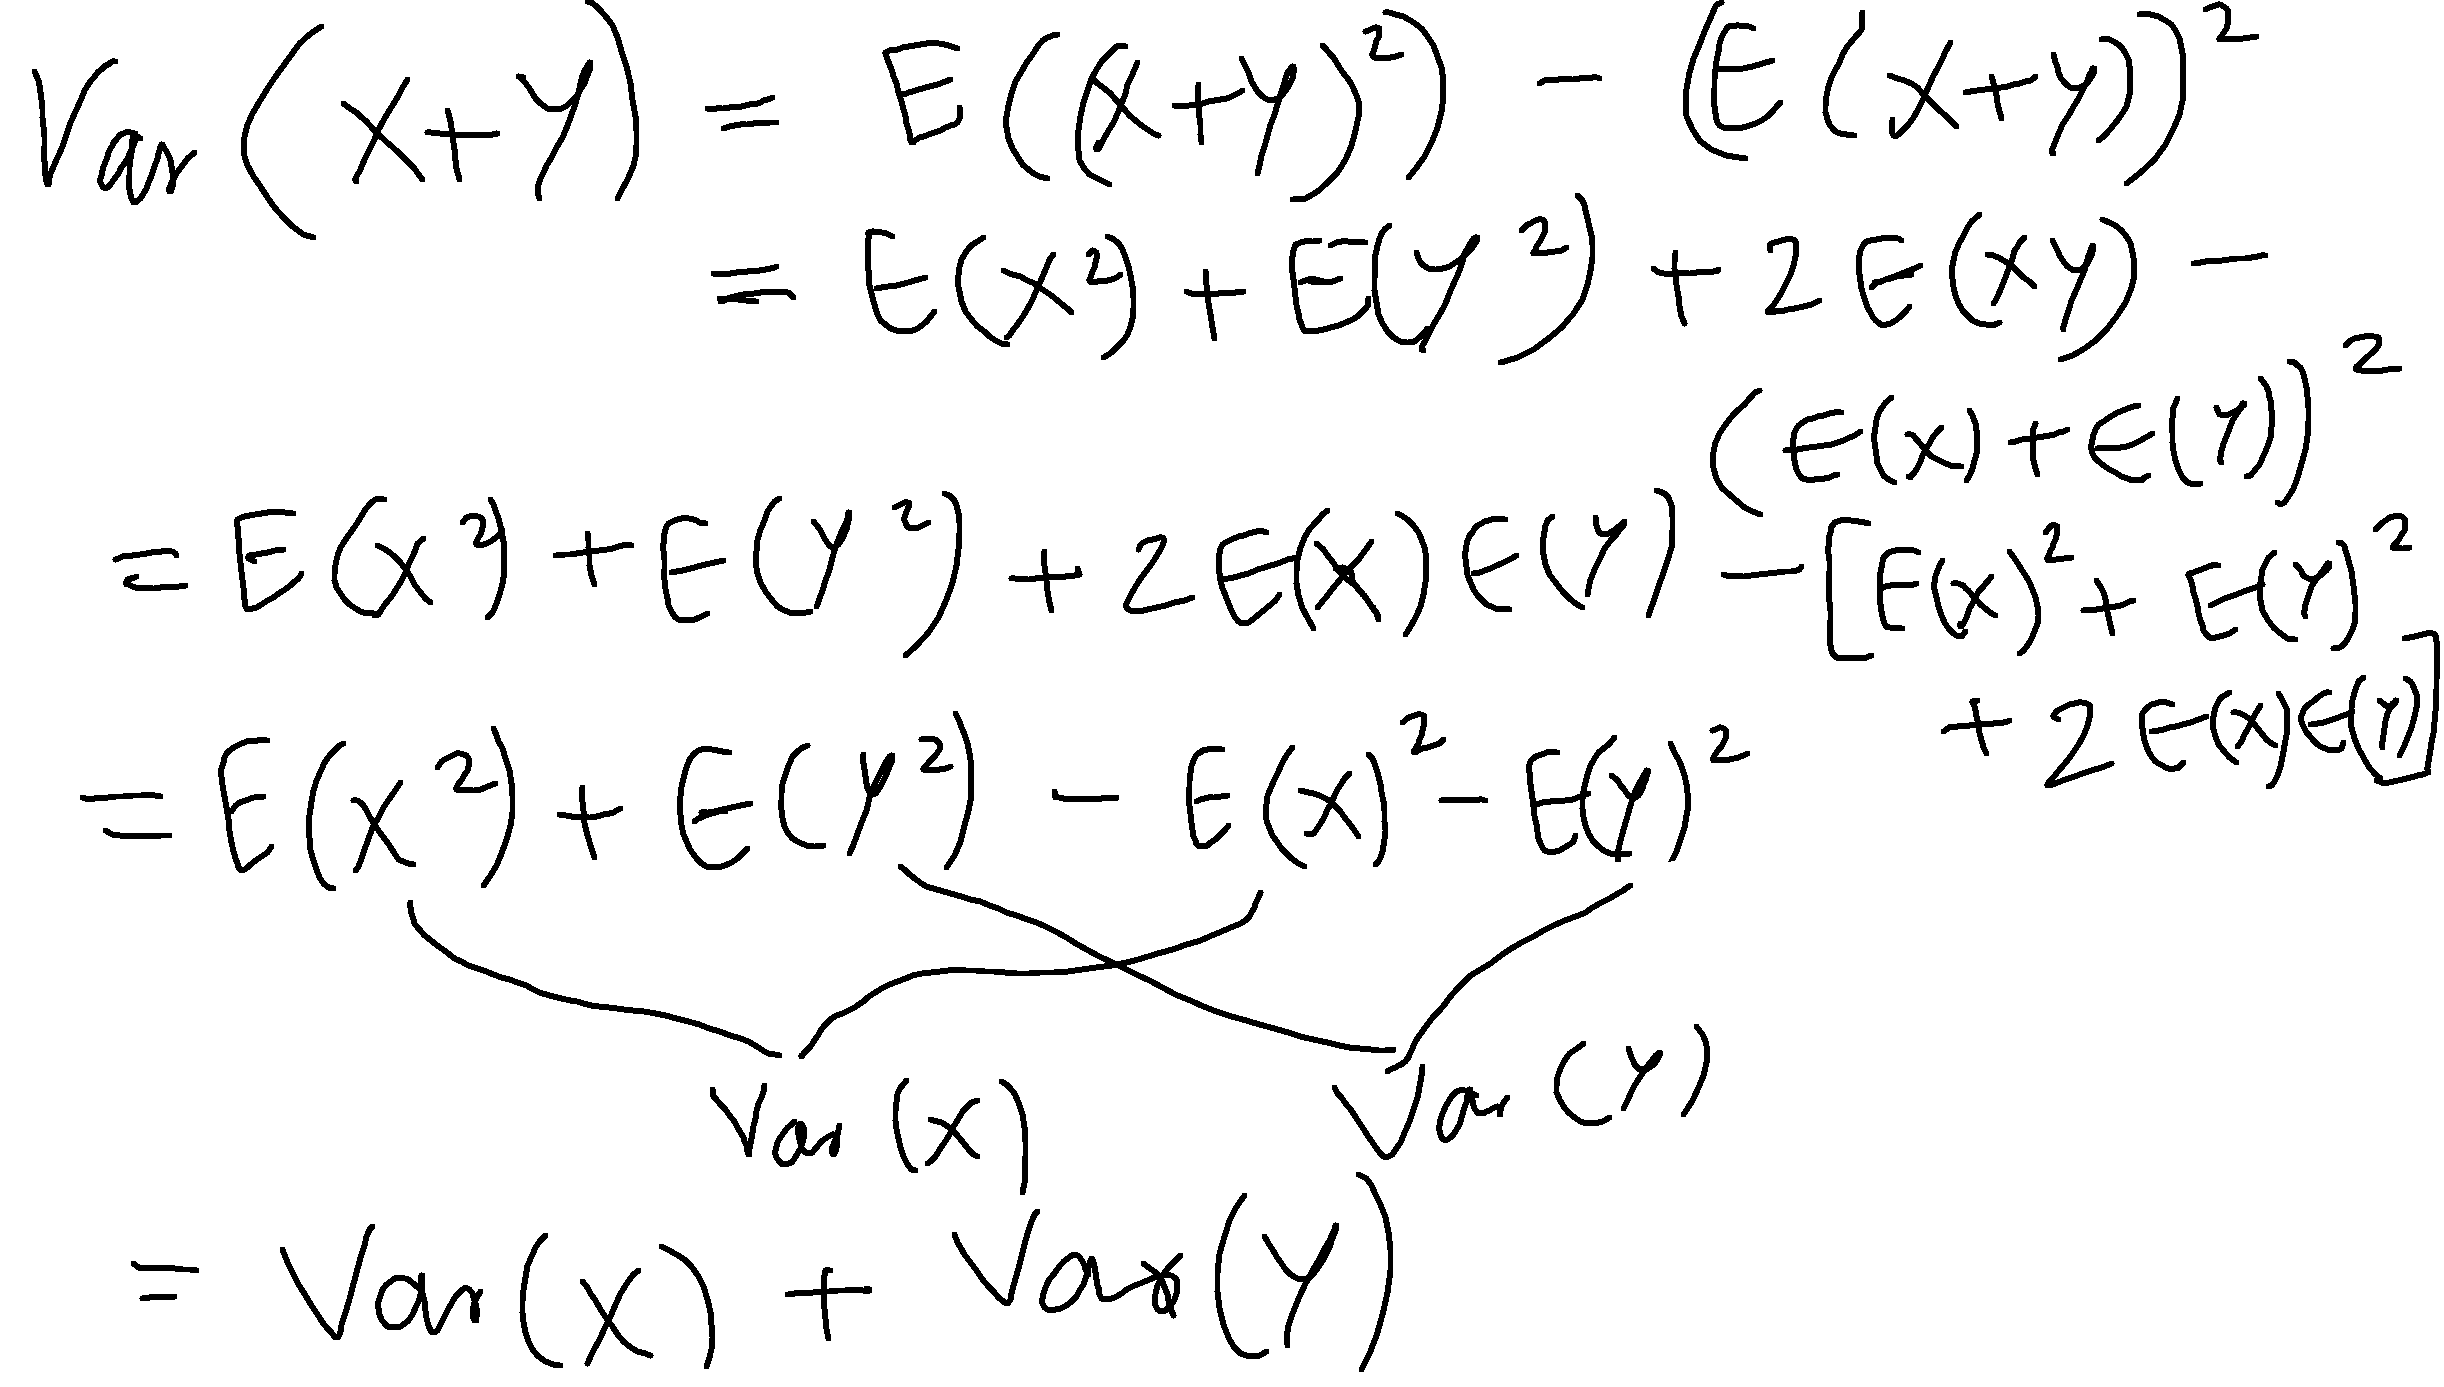

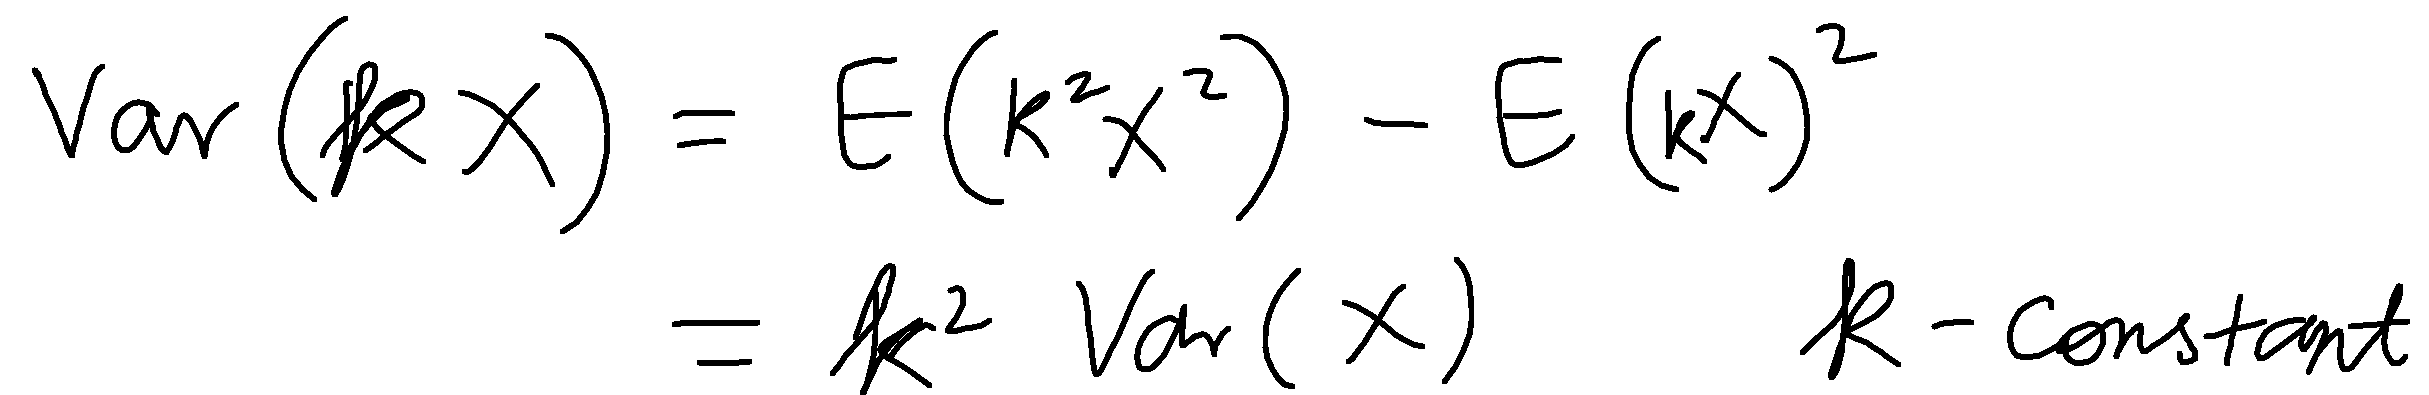

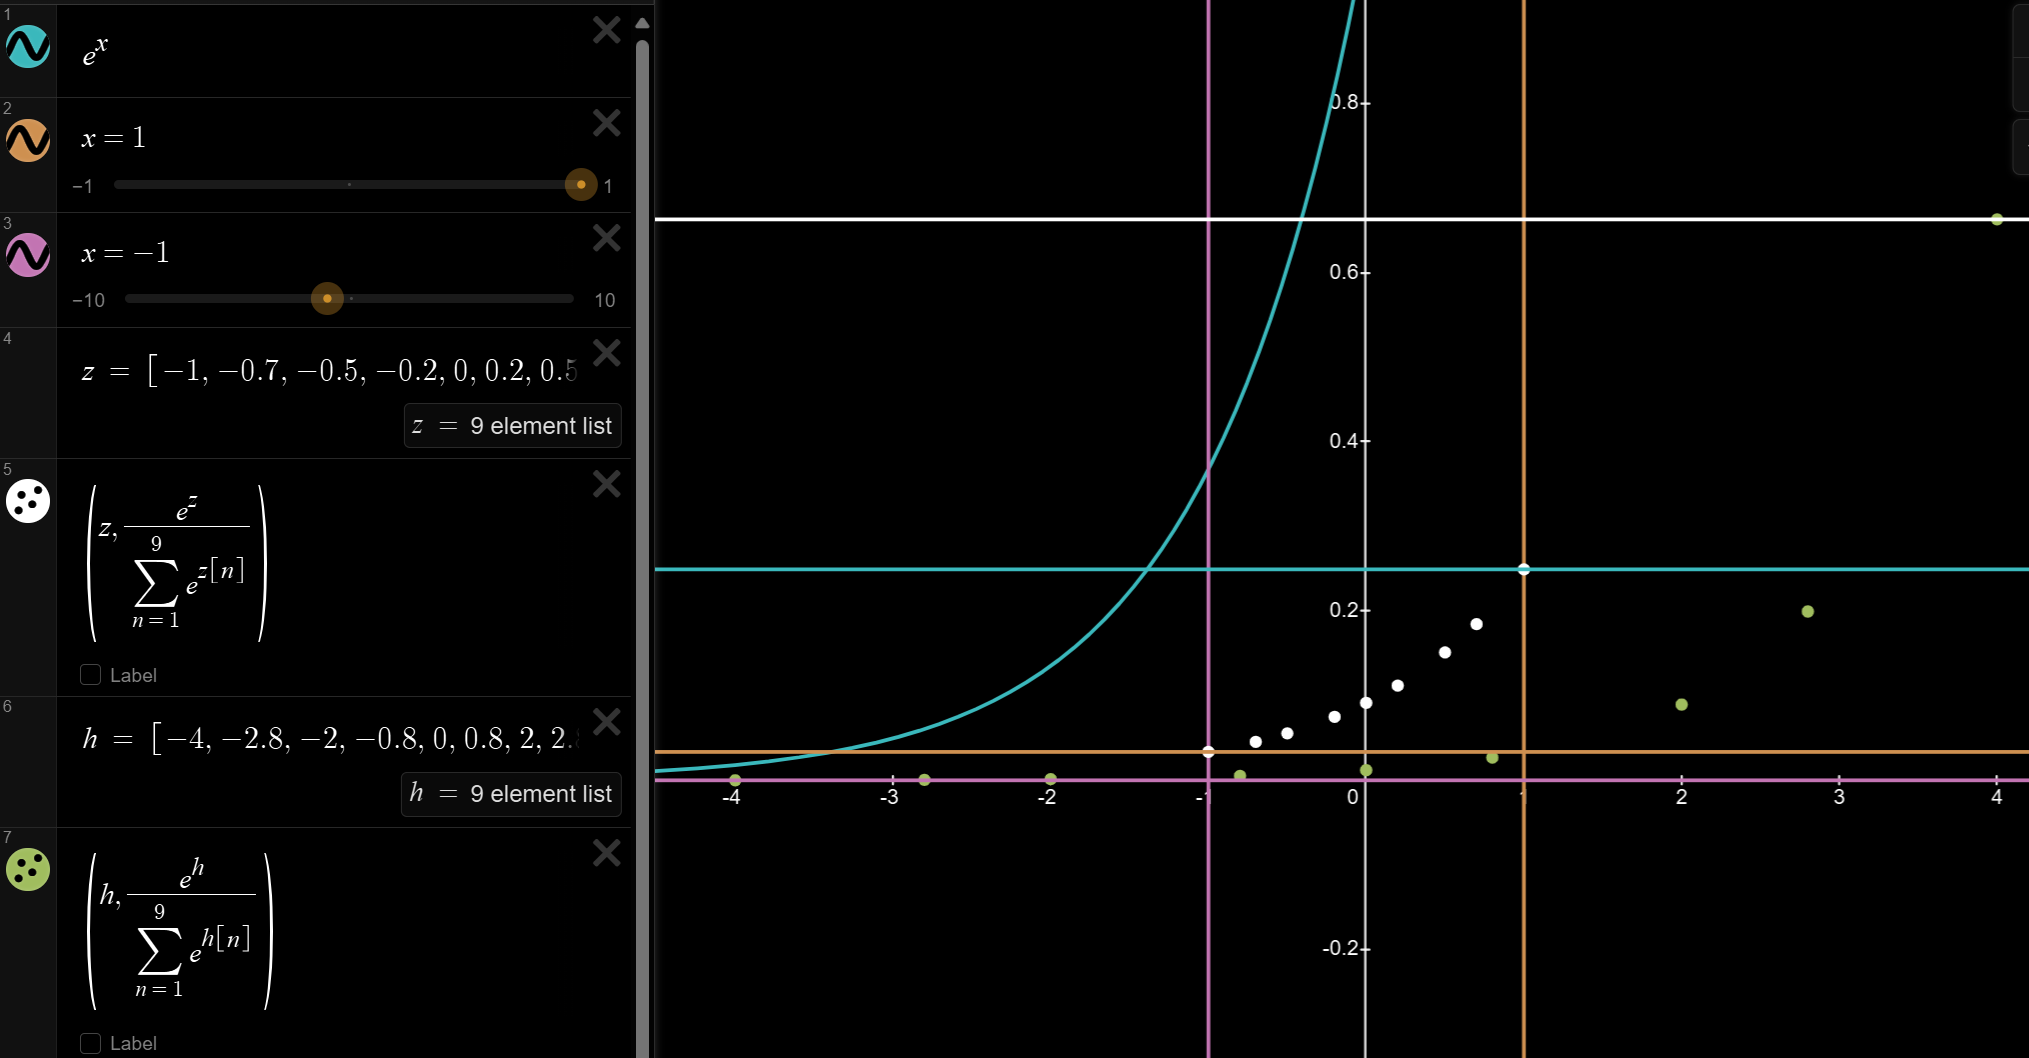

Notice how for z ~ N(0,1) the softmax is much more equitable, whereas for z ~ N(0,4) [std(4), var(16)] is more skewed

#### Continue

In [17]:
# 1.17.37 Video time stamp